The goal of this notebook is to verify our implementation of the DMDc algorithm

In [317]:
# Imports
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd

 
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
from scipy.signal import cont2discrete
import pyvista as pv
import h5py
import mat73
import dask.array as da
from dask.distributed import Client, LocalCluster
import opinf
config = dotenv_values(".env")
from util import *
from scipy import signal

from sympy import Matrix, init_printing
init_printing()


In [318]:
# # Setup Dask client
# # cluster = LocalCluster() # Launches a scheduler and workers locally
# # client = Client(cluster) # Connect to distributed cluster and override default
# client = Client('tcp://127.0.0.1:8786')
# client.cluster

In [319]:
# Hyperparameters for simulation
n = 1 # dimension of full order state
l = 1 # dimension of input vector
m = 1 # dimension of output vector

n_timesteps = 5000 # number of timesteps to simulate
dt = 0.01 # timestep size




In [320]:
# Make random linear system matrices with some sparsity where entries are drawn from normal distribution
A = np.random.rand(n,n) 
# A[np.abs(A<0.4)] = 0
A = A - np.diag(np.sum(A, axis=0))
B = np.random.rand(n, l)
# Make C a pass-through matrix
# C=np.eye(m,n)

C = np.random.rand(m, n)
D = np.zeros((m, l))



In [321]:
# Make discrete time linear system
dMats = signal.cont2discrete((A, B, C, D), dt=dt)
# sys = signal.dlti(dMats[0], dMats[1], dMats[2], dMats[3], dt=dt)
A_d = dMats[0] # np.array([0.5]) 
B_d = dMats[1] # np.array([1]) 
C_d = dMats[2] # np.array([1]) 
D_d = dMats[3] # np.array([0]) 

In [322]:
# Set initial condition and input
x0 = np.zeros((n, 1))
u = (np.random.rand(l, n_timesteps)-0.5)
# u = np.cumsum(u, axis=1)
#np.sin(np.linspace(0, 10, n_timesteps))

# Set amount of gaussian noise to add to input
eps_input = 0.0005
eps_output = 0.00001

In [323]:
# Simulate discrete time linear system
# Initialize array to hold state data and output data
X_fom = np.zeros((n, n_timesteps))
X_fom[:, [0]] = x0
Y_fom = np.zeros((m, n_timesteps))
Y_fom[:, [0]] = np.dot(C_d, x0)

In [324]:
# Simulate system
for i in range(1, n_timesteps):
    X_fom[:, i] = np.dot(A_d, X_fom[:, i-1]) + np.dot(B_d, u[:,i-1]) #+ np.random.normal(0, eps_input, (n, 1))[:,0]
    Y_fom[:, i] = np.dot(C_d, X_fom[:, i])  + np.random.normal(0, eps_output, (m, 1))[:,0] #+ np.dot(D_d, u[:,i-1])

In [325]:
# Make Koopman Data matrices with time delay embeddings of N_delay timesteps and polynomial embeddings of up to N_polynomial for each episode
N_delay = 1 # number of time delay embeddings
N_poly = 1 # highest order polynomial to embed
Z_fom = np.zeros((m*(N_delay+N_poly) , n_timesteps))
for i in range(0, n_timesteps):
    # Time delay embeddings
    for j in range(N_delay+1):
        # fill 0s if not enough data
        if i-j< 0:
            Z_fom[j*m:(j+1)*m, i] = 0
        else:
            Z_fom[j*m:(j+1)*m, i] = Y_fom[:, i-j]
    # Polynomial embeddings
    for j in range(N_poly-1):
        Z_fom[(j+N_delay+1)*m:(j+N_delay+2)*m, i] = np.power(Y_fom[:, i], j+2)


In [326]:
# Make DMDc data matrices
X_train = da.from_array(Z_fom[:, :-1], chunks=(m*(N_delay+1), 4000))
Xprime_train = da.from_array(Z_fom[:, 1:], chunks=(m*(N_delay+1), 4000))
Upsilon_train = da.from_array(u[:, :-1], chunks=(l, 4000))
Y_train = da.from_array(Y_fom[:, :-1], chunks=(m, 4000))

In [327]:
# Compute DMDc ROM
p_dmd = int(m*(N_delay+N_poly))# dimension of reduced input space
n_ROM = p_dmd # dimension of reduced order state
# Form snapshot matrices for DMDc
Omega = da.concatenate([X_train,Upsilon_train],axis=0)
Omega = Omega.rechunk((Omega.shape[0],4000))
print("got here 4")
# Decompose snapshot matrix using truncated SVD
# r_dmd = n_ROM
print("got here 5")
U_tilde,Sigma_tilde,Vh_tilde = da.linalg.svd(Omega)
# Vh_tilde = da.conj(da.transpose(V_tilde))
Sigma_tilde = da.diag(Sigma_tilde)
# U_hat, Sigma_hat, V_hat = da.linalg.svd_compressed(Xprime_train, r_dmd)
# Sigma_hat = da.diag(Sigma_hat)
print("got here 6")
# Compute system state evolution matrices
# U_tilde_1 = U_tilde[0:m*N_delay,:]
# U_tilde_2 = U_tilde[m*N_delay:,:]
stateMats = Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde.conj().T)
# A_dmdc = Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_1.conj().T)
# B_dmdc = Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_2.conj().T)
A_dmdc = stateMats[:,0:n_ROM]
B_dmdc = stateMats[:,n_ROM:]

# C matrix just extracts the first m states
C_dmdc = da.concatenate([da.eye(m),da.zeros((m,m*(N_delay+N_poly-1)))],axis=1)

# A_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_1.conj().T)@U_hat
# B_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_2.conj().T)

# print("got here 7")

# # Solve for system output matrix from full order system
# ys = Y_train[:,0:250]

# compute approximate pseudoinverse of data matrix using SVD
# X_train = X_train.rechunk((2000,X_train.shape[1])) # Rechunk along one dimension
# U_X_train, S_X_train, Vh_X_train = da.linalg.svd(X_train[:,0:250])
# X_PI = da.matmul(da.transpose(Vh_X_train),da.matmul(da.diag(da.reciprocal(S_X_train)),da.transpose(U_X_train)))

# print("got here 8")

# # # X_PI = np.linalg.pinv(X_train[:,0:10])
# C_dmdc = ys@X_PI
# C_dmdc = C_dmdc@U_hat
# print("got here 9")
# # Execute computations for dmdc system matrices
# print("Computing DMDc system matrices for n_ROM = ", n_ROM)
# A_dmdc, B_dmdc, C_dmdc,U_hat = da.compute(A_dmdc, B_dmdc, C_dmdc,U_hat)
A_dmdc, B_dmdc, C_dmdc = da.compute(A_dmdc, B_dmdc, C_dmdc)
# # A_dmdc, B_dmdc = da.compute(A_dmdc, B_dmdc)
# # A_dmdc = A_dmdc.compute()
# print("got here 10")
# # B_dmdc = B_dmdc.compute()
# # print("got here 11")
# # C_dmdc = C_dmdc.compute()
# # print("got here 12")
# # U_hat = U_hat.compute()
# # print("got here 13")
# basis_dmdc = U_hat[:,0:n_ROM]



got here 4
got here 5
got here 6


In [328]:
# Simulate koopman dynamics from the N_delay-th timestep
X_koop = np.zeros((n_ROM, n_timesteps))
X_koop[:, [0]] = np.zeros((n_ROM, 1))
Y_koop = np.zeros((m, n_timesteps))
for i in range(1, n_timesteps):
    X_koop[:, [i]] = A_dmdc@X_koop[:, [i-1]] + B_dmdc@u[:, [i-1]]
    Y_koop[:, [i]] = C_dmdc@X_koop[:, [i]]

In [329]:
# Display system matrices
display(Matrix(A_dmdc))

⎡1.000050646392  -5.06086063681672e-5⎤
⎢                                    ⎥
⎣     1.0        8.71527953944978e-17⎦

Text(0.5, 1.0, 'Koopman Model')

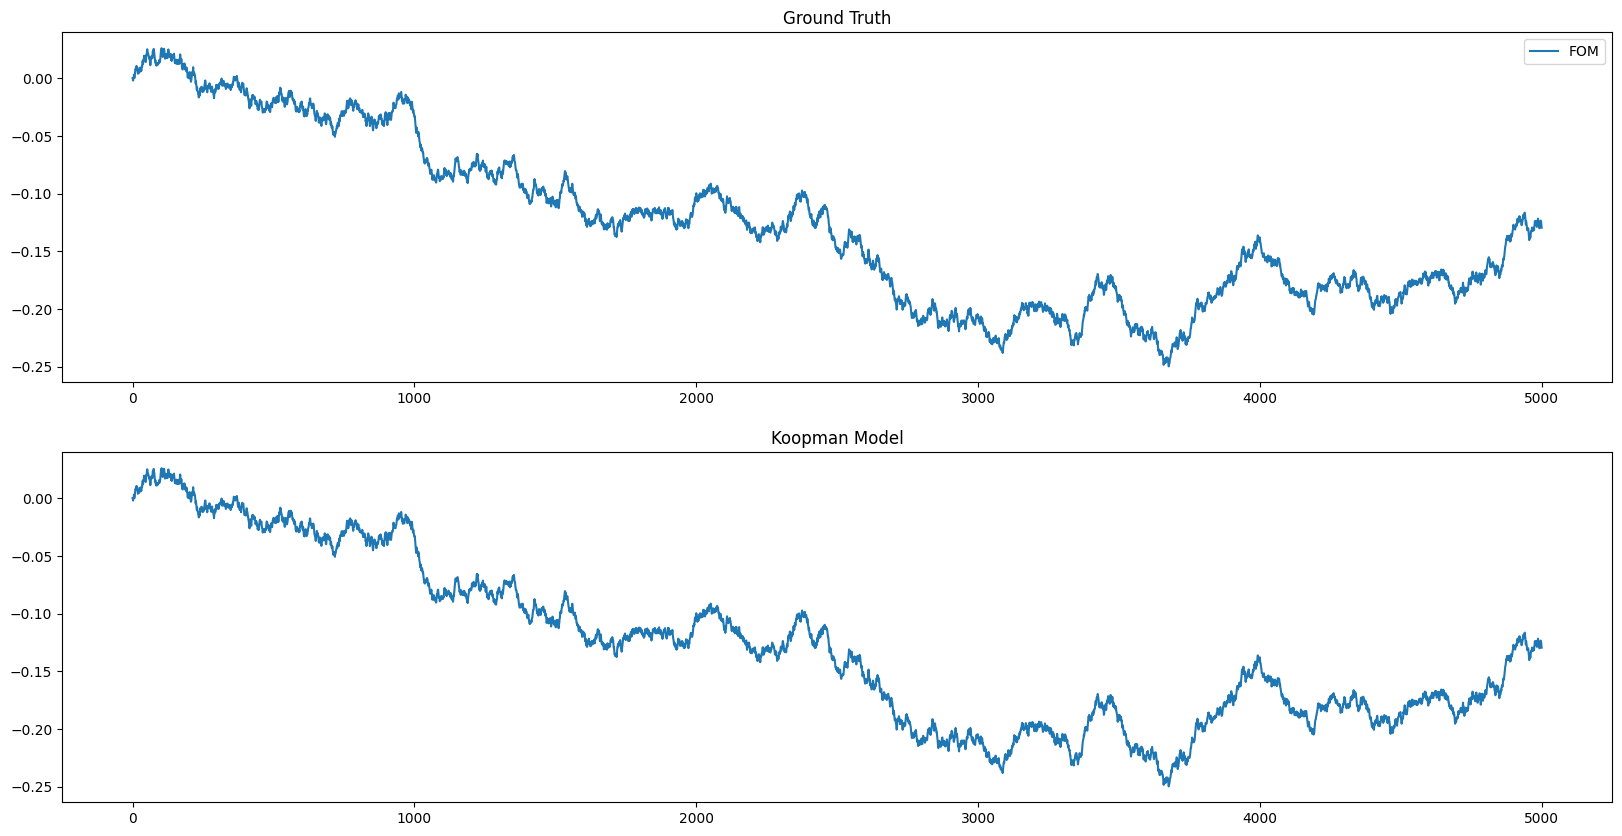

In [330]:
# Plot results against ground truth on different subplots ignoring the first N_delay timesteps
index = 0 
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(Y_fom[index, :], label='FOM')
plt.title('Ground Truth')
plt.legend()
plt.subplot(2,1,2)
plt.plot(Y_koop[index, :], label='Koopman')
plt.title('Koopman Model')

In [331]:
Y_koop.shape

In [332]:
# Compute relative errors between FOM and DMDc states and outputs
# X_err = np.linalg.norm(X_fom - X_dmdc_full)/np.linalg.norm(X_fom)
Y_err = np.linalg.norm(Y_fom - Y_koop)/np.linalg.norm(Y_fom)
# print("X error: ", X_err)
print("Y error: ", Y_err)

Y error:  0.00016961180246944456


In [333]:
# # Print off original and computed system matrices
# print("Original: A = ", A_d, ", B = ", B_d, ", C = ", C_d)
# print("DMDc: A = ", A_dmdc, ", B = ", B_dmdc, ", C = ", C_dmdc)

# Using Koopman ROM on real data

In [334]:
####### Set up dask cluster #######
# Setup Dask client
# cluster = LocalCluster() # Launches a scheduler and workers locally
# client = Client(cluster) # Connect to distributed cluster and override default
client = Client('tcp://127.0.0.1:8786')
client.cluster

####### # Set up hyperparameters for all ROMs  #######
n_timesteps = 2000 # Number of timesteps to pull from each episode
dt = 0.001
n_train = 3 # Number of training episodes
ns_ROM = np.arange(2,202,2) # Dimensions of ROM state space



####### Set up filepaths #######
# Setup filepaths for reading data 
filepath = config["currentDirectory"] + "data/archivedDataSets/FullAssembly_Constrained_FullSetForRAL_goodMatParams/"
romDir = config["currentDirectory"] + "data/archivedDataSets/FullAssembly_Constrained_FullSetForRAL_goodMatParams/ROMs/"

####### Load in data #######
print("Loading in data...")
# Read in all training data 
data = h5py.File(filepath+ "fullDataSet.hdf5", 'r')
X_fom = da.from_array(data["stateData"], chunks=(4096, 4096,1))
X_fom = X_fom[:,:,0:n_train]
U_fom = da.from_array(data["inputData"], chunks=(4096, 4096,1))
U_fom = U_fom[:,:,0:n_train]
Y_fom = da.from_array(data["reducedCenterlineData"], chunks=(4096, 4096,1))
Y_fom = Y_fom[:,:,0:n_train]
x0 = data["stateData"][:,0,0]
y0 = data["reducedCenterlineData"][:,0,0]
n = X_fom.shape[0]
l = U_fom.shape[0]
m = Y_fom.shape[0]
# # Collect initial condition offsets for each episode and center each episode
X0 = da.zeros((n,n_train))
Y0 = da.zeros((m,n_train))
for i in range(n_train):
    X0[:,i] = X_fom[:,0,i]
    Y0[:,i] = Y_fom[:,0,i]
    X_fom[:,:,i] = X_fom[:,:,i] - X0[:,i].reshape(-1,1)
    Y_fom[:,:,i] = Y_fom[:,:,i] - Y0[:,i].reshape(-1,1)
print("Done loading in data.")

# Get length of robot from min and max of x coords
xzCoords = Y0[:,0].reshape(-1,2)

x_min = np.min(xzCoords[:,0])
x_max = np.max(xzCoords[:,0])
length = x_max - x_min
print("Length of robot: ", length.compute())
# Get z min and max
z_min = np.min(xzCoords[:,1])
z_max = np.max(xzCoords[:,1])


Loading in data...
Done loading in data.
Length of robot:  1110.065638621652


In [335]:
# Convert inputs and outputs to np arrays
U_fom = U_fom.compute()
Y_fom = Y_fom.compute()


In [336]:
# Extract Z outputs from Y
Y_fom = Y_fom[1::2,:,:]

m = int(m/2)

In [428]:
# Make Koopman Data matrices with time delay embeddings of N_delay timesteps and polynomial embeddings of up to N_polynomial for each episode
N_delay = 6 # number of time delay embeddings
N_poly = 1 # highest order polynomial to embed
Z_fom = np.zeros((m*(N_delay+N_poly) , n_timesteps, n_train))
for epInd in range(n_train):
    for i in range(0, n_timesteps):
        # Time delay embeddings
        for j in range(N_delay+1):
            # fill 0s if not enough data
            if i-j< 0:
                Z_fom[j*m:(j+1)*m, i,epInd] = 0
            else:
                Z_fom[j*m:(j+1)*m, i,epInd] = Y_fom[:, i-j,epInd]
        # Polynomial embeddings
        for j in range(N_poly-1):
            Z_fom[(j+N_delay+1)*m:(j+N_delay+2)*m, i,epInd] = np.power(Y_fom[:, i,epInd], j+2)


In [429]:
# Flatten Z_fom and U_fom to be 2D by concatenating episodes together along columns
Z_fom_flat = np.zeros((m*(N_delay+N_poly), n_timesteps*n_train))
U_fom_flat = np.zeros((l, n_timesteps*n_train))
Y_fom_flat = np.zeros((m, n_timesteps*n_train))
for epInd in range(n_train):
    Z_fom_flat[:,epInd*n_timesteps:(epInd+1)*n_timesteps] = Z_fom[:,:,epInd]
    U_fom_flat[:,epInd*n_timesteps:(epInd+1)*n_timesteps] = U_fom[:,:,epInd]
    Y_fom_flat[:,epInd*n_timesteps:(epInd+1)*n_timesteps] = Y_fom[:,:,epInd]

In [430]:
# Make DMDc data matrices
X_train = da.from_array(Z_fom_flat[:, :-1], chunks=(m*(N_delay+N_poly), 4000))
Xprime_train = da.from_array(Z_fom_flat[:, 1:], chunks=(m*(N_delay+N_poly), 4000))
Upsilon_train = da.from_array(U_fom_flat[:, :-1], chunks=(l, 4000))
Y_train = da.from_array(Y_fom_flat[:, :-1], chunks=(m, 4000))


In [431]:
X_train.shape

In [432]:
# Compute DMDc ROM
p_dmd = int(m*(N_delay+N_poly))# dimension of reduced input space
n_ROM = p_dmd # dimension of reduced order state
# Form snapshot matrices for DMDc
Omega = da.concatenate([X_train,Upsilon_train],axis=0)
Omega = Omega.rechunk((Omega.shape[0],4000))
print("got here 4")
# Decompose snapshot matrix using truncated SVD
# r_dmd = n_ROM
print("got here 5")
U_tilde,Sigma_tilde,Vh_tilde = da.linalg.svd(Omega)
# Vh_tilde = da.conj(da.transpose(V_tilde))
Sigma_tilde = da.diag(Sigma_tilde)
# U_hat, Sigma_hat, V_hat = da.linalg.svd_compressed(Xprime_train, r_dmd)
# Sigma_hat = da.diag(Sigma_hat)
print("got here 6")
# Compute system state evolution matrices
# U_tilde_1 = U_tilde[0:m*N_delay,:]
# U_tilde_2 = U_tilde[m*N_delay:,:]
stateMats = Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde.conj().T)
# A_dmdc = Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_1.conj().T)
# B_dmdc = Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_2.conj().T)
A_dmdc = stateMats[:,0:n_ROM]
B_dmdc = stateMats[:,n_ROM:]

# C matrix just extracts the first m states
C_dmdc = da.concatenate([da.eye(m),da.zeros((m,m*(N_delay+N_poly-1)))],axis=1)


A_dmdc, B_dmdc, C_dmdc = da.compute(A_dmdc, B_dmdc, C_dmdc)


got here 4
got here 5
got here 6


In [433]:
1000# # Compute svd matrices
# U_tilde,Sigma_tilde,Vh_tilde = da.linalg.svd(Omega)
# U_tilde,Sigma_tilde,Vh_tilde = da.compute(U_tilde,Sigma_tilde,Vh_tilde)

In [434]:
# Simulate koopman dynamics from the N_delay-th timestep for each episode
X_koop = np.zeros((n_ROM, n_timesteps, n_train))
# X_koop[:, [0]] = np.zeros((n_ROM, 1))
Y_koop = np.zeros((m, n_timesteps, n_train))
for epInd in range(n_train):
    for i in range(1, n_timesteps):
        X_koop[:, [i],epInd] = A_dmdc@X_koop[:, [i-1],epInd] + B_dmdc@U_fom[:, [i-1],epInd]
        Y_koop[:, [i],epInd] = C_dmdc@X_koop[:, [i],epInd]

Text(0.5, 1.0, 'Koopman Model')

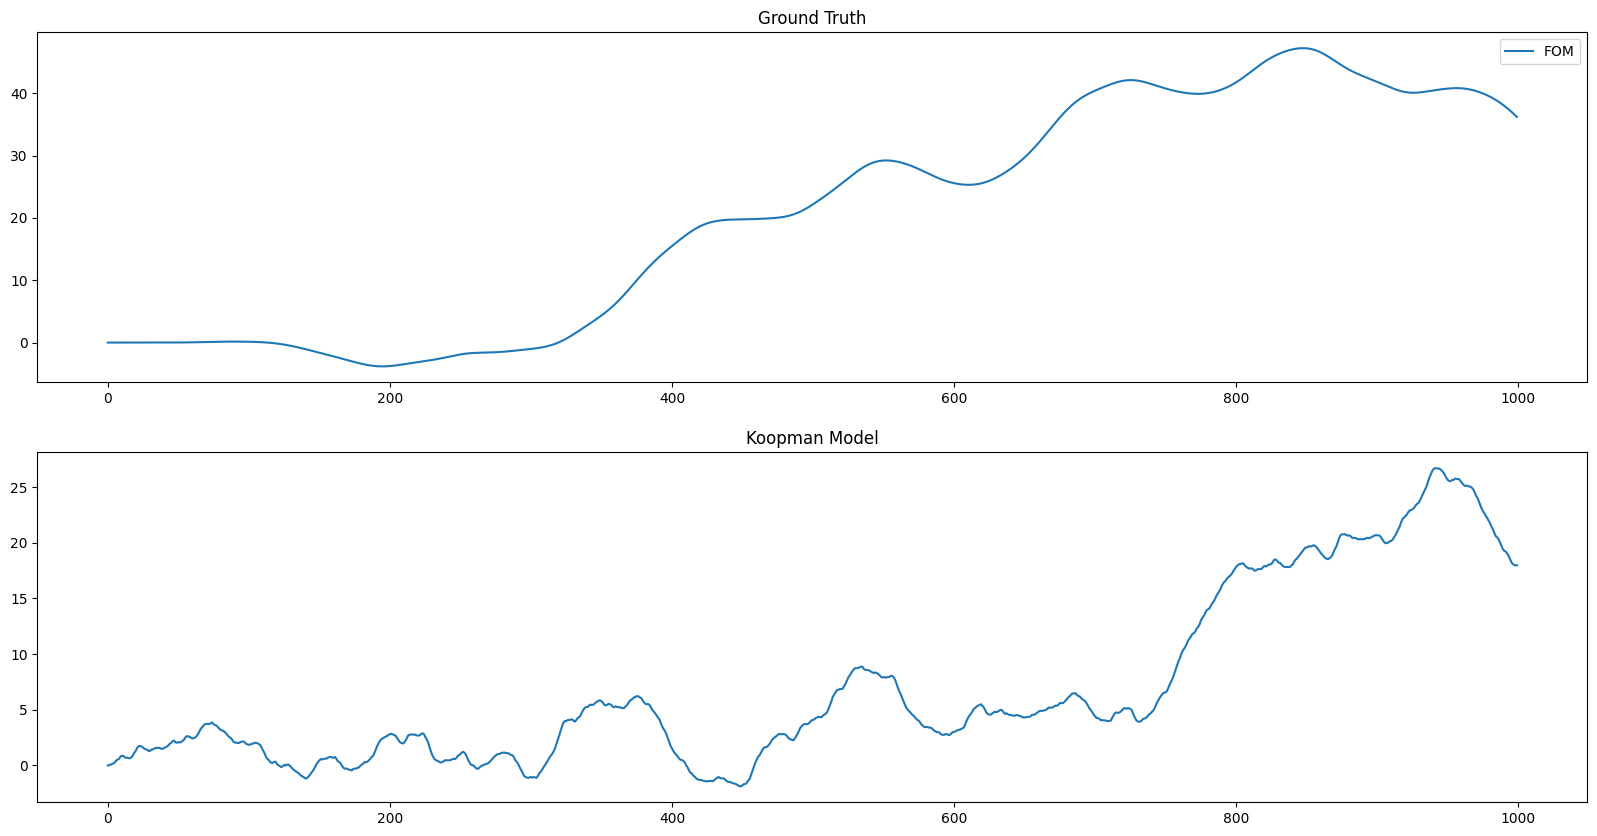

In [438]:
# Plot results against ground truth on different subplots ignoring the first N_delay timesteps
index = 1
epInd = 0
plotSteps = 2000
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(Y_fom[index, :plotSteps, epInd], label='FOM')
plt.title('Ground Truth')
plt.legend()
plt.subplot(2,1,2)
plt.plot(Y_koop[index, :plotSteps, epInd], label='Koopman')
plt.title('Koopman Model')

In [436]:
# Compute relative errors between FOM and DMDc states and outputs
# X_err = np.linalg.norm(X_fom - X_dmdc_full)/np.linalg.norm(X_fom)
Y_err = np.linalg.norm(Y_fom - Y_koop)/np.linalg.norm(Y_fom)
# print("X error: ", X_err)
print("Y error: ", Y_err)

Y error:  4.227706955966481


In [437]:
A_dmdc.shape